In [1]:
from C4I import benchmarks, clustering, evaluation, investment, risk_factors, utils
import pandas as pd
import numpy as np
import pickle

Source


In [2]:
def An_Unsupervised_Learning_Framework(X, n_pcs, len_fold, n_win,temp_path=None,
                                scaler_pre='MinMax', coll_threshold=0.5, SEED=1,
                                lasso_fold=5, min_rfs=2, max_rfs=4, n_round=3,
                                scaler='Standard',
                                opt_hyper_port={'maxiter':200, 'disp':True},
                                port_select=3, verbose=True):
    '''
    INPUT:
        X: DataFrame, contains assets daily prices
        n_pcs: number of Principal Components to consider
        len_fold: int, length of each fold
        n_win: int, number of windows for the pooled regression
        temp_path: None or str, path for temp savings. If None, there are no
            temp savings. Default=None
        scaler_pre: str representing the scaler to use in preprocessing, either
            'Standard' or 'MinMax'. Other values will result in no scaling.
            Default='Standard'
        coll_threshold: float, correlation threshold for collinearity filter
        SEED: int, seed to set random values
        lasso_fold: int, number of folds for the cross validation. Default = 5
        min_rfs: int, minimum number of risk factors to be saved. Default = 2
        max_rfs: int, maximum number of risk factors to be saved. Default = 4
        n_round: int, number of decimals considered (if <=0, no round).Default=3
        scaler: str representing the scaler to use, either 'Standard' or
            'MinMax'. Other values will result in no scaling. Default='Standard'
        opt_hyper_port: dcit, hyperparameters for the minimizer, containing two
            keys: 'maxiter' and 'disp'. Default={'maxiter':200, 'disp':True}
        port_select: int, number of portfolios to select. Default=3
        verbose: bool, manages the verbosity. Default=True
    OUTPUT:
        target_portfolios: list, containing weights of the optimal portfolio
    '''
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    
    #----- From prices to returns
    X.index = pd.to_datetime(X.index)
    # Monthly returns
    XM = utils.DailyPrice2MonthlyReturn(X)
    # Daily returns
    XD = utils.DailyPrice2DailyReturn(X)
    # Scale data
    if scaler_pre == 'Standard':
        XD = pd.DataFrame( StandardScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( StandardScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    elif scaler_pre == 'MinMax':
        XD = pd.DataFrame( MinMaxScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( MinMaxScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    
    #----- Create Risk Factors
    if temp_path != None:
        try:
            PCs = pd.read_csv(f'{temp_path}/RiskFactors.csv', index_col=0)
            PCs.index = pd.to_datetime(PCs.index)
        except:
            PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                                 gran_names=['Daily','Monthly'],
                                                 threshold=coll_threshold,
                                                 SEED=SEED)
            PCs.to_csv(f'{temp_path}/RiskFactors.csv')
    else:
        PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                             gran_names=['Daily', 'Monthly'],
                                             threshold=coll_threshold,SEED=SEED)
    if verbose:
        print('Risk Factors successfully extracted!\n')

    #----- Apply Features Selection
    #Check if there are previous savings
    if temp_path != None:
        try:
            with open(f'{temp_path}/Saved_RFs.pickle','rb') as f:
                saved_rf = pickle.load(f)
        except:
            saved_rf = dict()
    else:
        saved_rf = dict()
    #Go on with features selection
    Grid = {'alpha':np.logspace(-11, -2, num=25, base=np.e),
        'tau':np.linspace(0.5, 1.5, 11)}
    
    cnt = 0
    for col in XD.columns[len(saved_rf.keys()):]:
        cnt += 1
        if verbose:
            print(f'Optimizing hyperparameters for asset {col}')
            print(f'Optimizing hyperparemeters for asset num {cnt} remaining {len(XD.columns[len(saved_rf.keys()):])}')

        flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                   Exog=PCs.values,
                                                   grid=Grid,
                                                   n_fold=lasso_fold,
                                                   len_fold=len_fold,
                                                   min_rfs=min_rfs,
                                                   max_rfs=max_rfs,
                                                   scaler=scaler)
        #If the result is positive, store the hyperparameters
        if flag:
            saved_rf[col] = res
            if verbose:
                print(f'Optimization result: {res}')
        #Otherwise, make a new, more accurate search
        else:
            if res == -1:
                temp_Grid = {'alpha':np.logspace(-16, -11,num=25,base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            elif res == 1:
                temp_Grid = {'alpha':np.logspace(-3, 3, num=25, base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            else:
                temp_Grid = {'alpha':np.logspace(-11, -2,num=40,base=np.e),
                            'tau':np.linspace(0.5, 2, 20)}
            flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                       Exog=PCs.values,
                                                       grid=temp_Grid,
                                                       n_fold=lasso_fold,
                                                       len_fold=len_fold,
                                                       min_rfs=min_rfs,
                                                       max_rfs=max_rfs,
                                                       scaler=scaler)
            if flag:
                saved_rf[col] = res
                if verbose:
                    print(f'Optimization result: {res}')
        if temp_path != None:
            with open(f'{temp_path}/Saved_RFs.pickle','wb') as f:
                pickle.dump(saved_rf, f)

    #----- Create Clustering
    #Create clusters
    clusters = clustering.Clustering(saved_rf)
    if verbose:
        print('Total clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]},\
            Cluster Dimension: {len(cluster[1])}')
            print(f'Assets in the cluster: {cluster[1]}')
    #Save useful clusters
    clusters = clustering.UsefulClusters(clusters, saved_rf)
    if verbose:
        print('\nUseful clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]}')
            print(f'Assets in the cluster: {cluster[1]}')

    #----- Investment Strategy
    target_portfolios = investment.Create_Portfolios(XD=XD, Exog=PCs.values,
                                        clusters=clusters,
                                        target_function=utils.Expected_Sharpe,
                                        windows_number=n_win,
                                        scaler=scaler, opt_hyper=opt_hyper_port,
                                        port_to_select=port_select)
    #Adjust portfolios weight to obtain one output portfolio
    for port in target_portfolios:
        port[1] = port[1]/port_select
    return target_portfolios


Modified code

In [3]:
dt = pd.to_datetime('2016-01-04 00:00:00-05:00')
print(dt.date())

2016-01-04


In [4]:
import matplotlib.pyplot as plt
import pandas as pd 

path = 'data'
base_line_data = 'Dataset'
X = pd.read_csv(f'{path}/close_price.csv')
X['Date'] = X['Date'].apply(lambda x: pd.to_datetime(x).date())

X.set_index('Date', inplace=True)
X.index = pd.to_datetime(X.index)
print(X.index)
print(X.head())
X.dropna(axis=1, how='any', inplace=True)
print(X.head())
test_start = '2019-12-21'
XD = utils.DailyPrice2DailyReturn(X)
X_Test = XD[ XD.index >= test_start ]
X = X[ X.index < test_start ]



DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-28',
               '2023-08-29', '2023-08-30'],
              dtype='datetime64[ns]', name='Date', length=1928, freq=None)
                   MMM        AOS        ABT       ABBV       ABMD        ACN  \
Date                                                                            
2016-01-04  113.048523  33.202068  37.160885  41.186237  85.239998  89.974754   
2016-01-05  113.541328  33.016586  37.152229  41.014664  85.000000  90.443031   
2016-01-06  111.254501  32.362957  36.840607  41.021812  85.300003  90.266327   
2016-01-07  108.544174  30.781895  35.957676  40.900269  81.919998  87.615585   
2016-01-08  108.174561  29.686659  35.204590  39.

Training and Testing

In [5]:

#Obtain portfolio value in the test set
target_portfolio = An_Unsupervised_Learning_Framework(X, n_pcs=7,
                                                        len_fold=42, n_win=50)

#Evaluate results
port_test = investment.Investment(X_Test, target_portfolio, initial_capital=1000)
print('\nProposed strategy')
evaluation.Strategy_Evaluation(port_test)
print('\n')



Risk Factors successfully extracted!

Optimizing hyperparameters for asset MMM
Optimizing hyperparemeters for asset num 1 remaining 464
Optimization result: [0, 5]
Optimizing hyperparameters for asset AOS
Optimizing hyperparemeters for asset num 2 remaining 463
Optimization result: [0, 5]
Optimizing hyperparameters for asset ABT
Optimizing hyperparemeters for asset num 3 remaining 462
Optimization result: [0, 2]
Optimizing hyperparameters for asset ABBV
Optimizing hyperparemeters for asset num 4 remaining 461
Optimization result: [0, 2, 5, 6]
Optimizing hyperparameters for asset ACN
Optimizing hyperparemeters for asset num 5 remaining 460
Optimization result: [0, 2, 6]
Optimizing hyperparameters for asset ATVI
Optimizing hyperparemeters for asset num 6 remaining 459
Optimization result: [0, 2]
Optimizing hyperparameters for asset ADM
Optimizing hyperparemeters for asset num 7 remaining 458
Optimization result: [0, 2]
Optimizing hyperparameters for asset ADBE
Optimizing hyperparemeters 

In [ ]:
#Evaluate benchmarks
min_test = benchmarks.Minimal_Variance_Portfolio(XD, X_Test)
print('Minimal Variance Portfolio')
evaluation.Strategy_Evaluation(min_test)
print('\n')

mean_var_test = benchmarks.Mean_Variance_Portfolio(XD, X_Test)
print('Mean-Variance Portfolio')
evaluation.Strategy_Evaluation(mean_var_test)
print('\n')

Plotting

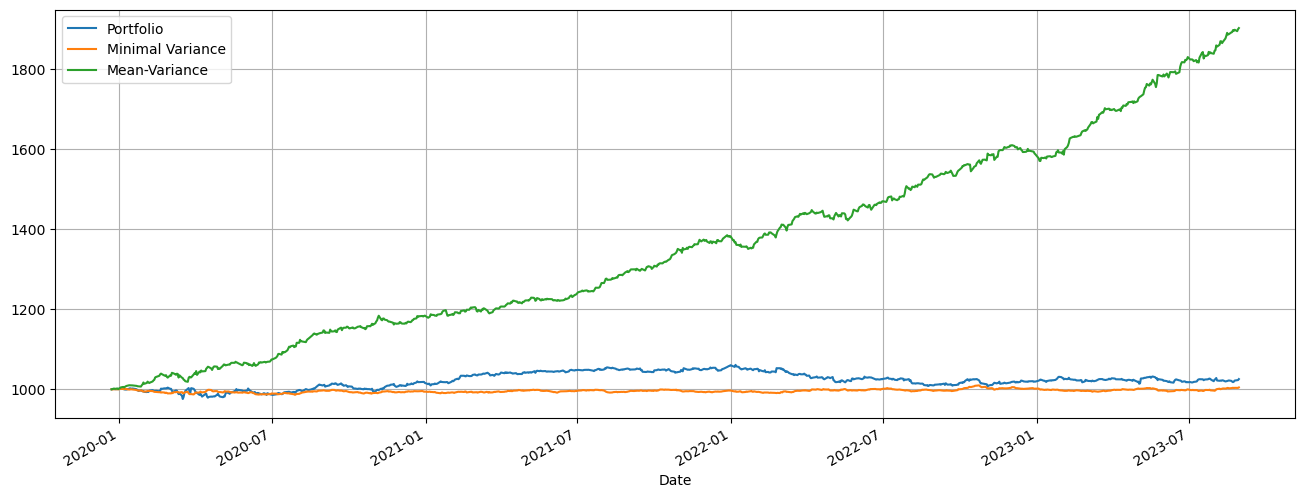

In [6]:
#Plot the results
port_test.plot(figsize=(16,6))
min_test.plot()
mean_var_test.plot()
plt.grid()
plt.legend()
plt.show()